In [1]:
from time import time
from joblib import Memory
from scipy import sparse
from scipy import linalg
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import nibabel as nib
import tempfile
from sklearn.datasets import make_regression
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import FeatureAgglomeration
from sklearn.cluster import ward_tree
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import SimpleITK as sitk
import six
from radiomics import featureextractor 
from radiomics import imageoperations
import numpy as np
from numpy import linalg



In [2]:
# Load first QSM and segmentation
seg1 = nib.load('D:/Elements Drive 2020/datasets/PD/12_28_2022/_QSM/034/seg.nii.gz')
qsm1 = nib.load('D:/Elements Drive 2020/datasets/PD/12_28_2022/_QSM/034/QSM.nii')
voxel_size = qsm1.header['pixdim'][0:3]

In [3]:
# Load second QSM and segmentation
seg2 = nib.load('D:/Elements Drive 2020/datasets/PD/12_28_2022/_QSM/035/seg.nii')
qsm2 = nib.load('D:/Elements Drive 2020/datasets/PD/12_28_2022/_QSM/035/QSM.nii.gz')
voxel_size = qsm2.header['pixdim'][0:3]

In [4]:

seg = np.array([seg1.get_fdata(),seg2.get_fdata()])
qsm = np.array([qsm1.get_fdata(),qsm2.get_fdata()])

In [ ]:
import os
segs = []
qsms = []
directory = 'D:/Elements Drive 2020/datasets/PD/12_28_2022/_QSM/'
for filename in os.listdir(directory):
    f = os.path.join(directory,filename)
    try:
        seg = nib.load(f+'/seg.nii')
    except:
        seg = nib.load(f+'/seg.nii.gz')
    segs = segs.append(seg)
    try:
        qsm = nib.load(f+'/qsm.nii')
    except:
        qsm = nib.load(f+'/qsm.nii.gz')
    qsms = qsms.append(qsm)
    

In [5]:
n_cases = seg.shape[0]

In [6]:
# Generate feature structure Phi from all ROIs and all cases

extractor = featureextractor.RadiomicsFeatureExtractor()
extractor.disableAllFeatures()
extractor.enableFeatureClassByName('firstorder')
Phi = []
for i in range(n_cases):
    seg_sitk = sitk.GetImageFromArray(seg[i])
    seg_sitk.SetSpacing(voxel_size.tolist())
    qsm_sitk = sitk.GetImageFromArray(qsm[i])
    qsm_sitk.SetSpacing(voxel_size.tolist())
    for j in range(1,int(np.max(seg))+1):
        featureVector = extractor.execute(qsm_sitk,seg_sitk,label=j)
        Phi.append(featureVector)


In [7]:
delta = len(Phi)/n_cases

In [8]:
# Extract numeric feature values
x_row = []
loop_count = 0
for i in range(n_cases):
    for j in range(int(np.max(seg))):
        featureVector = Phi[j]
        loop_count = loop_count+1
        for key, value in six.iteritems(featureVector):
            if 'diagnostic' in key:
                next
            else:
                x_row.append(value)


X0 = np.array(x_row)


In [9]:
X = X0.reshape((n_cases,int(len(X0)/n_cases)))

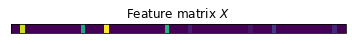

In [10]:
# Visualize feature matrix X
fig,ax = plt.subplots(1,1)
plt.style.use('dark_background')
plt.imshow(X)
plt.xticks([])
plt.yticks([])
plt.title('Feature matrix $X$');


In [15]:
Xt = ward_tree(X)

In [47]:
u = np.array([[3,8,32,4],
	[0,0,0,0],
	[0,10,33,4],
	[2,10,26,8],
	[0,0,0,0],
	[3,10,24,2],
	[0,0,0,0],
	[1,3,18,2],
	[2,13,30,6],
	[0,0,0,0],
	[0,0,0,0],
	[0,0,0,0],
	[0,0,0,0]])


In [46]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

# u1 = np.expand_dims(np.array([0,1,24,1]).T,0)
# u2 = np.expand_dims(np.array([0,3,21,3]).T,0)
# u = np.vstack((u1,u2))
cv = KFold(2)  # cross-validation generator for model selection
cachedir = tempfile.mkdtemp()
mem = Memory(location=cachedir, verbose=1)
lasso = Lasso(alpha=0.1,fit_intercept=False,max_iter=10000,tol=0.1)
ward = FeatureAgglomeration(n_clusters=10, memory=mem)
clf = Pipeline([("ward", ward), ("LASSO", lasso)])
# Select the optimal number of parcels with grid search
clf = GridSearchCV(clf, {"ward__n_clusters": [10, 20, 30]}, n_jobs=1, cv=cv)
clf.fit(X,u)  # set the best parameters
coef_ = clf.best_estimator_.steps[-1][1].coef_
coef_ = clf.best_estimator_.steps[0][1].inverse_transform(coef_)


________________________________________________________________________________
[Memory] Calling sklearn.cluster._agglomerative.ward_tree...
ward_tree(array([[0.],
       ...,
       [0.]]), connectivity=None, n_clusters=None, return_distance=False)
________________________________________________________ward_tree - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.cluster._agglomerative.ward_tree...
ward_tree(array([[0., 0.],
       ...,
       [0., 0.]]), connectivity=None, n_clusters=None, return_distance=False)
________________________________________________________ward_tree - 0.0s, 0.0min


c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\pipeline.py:394: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemente